In [1]:
import os
import time

# import pretty_errors

from transformers import AutoTokenizer
from ohara.models.phi import Phi, PhiConfig, Block,PhiMHA

from ohara.models.mamba import MambaBlock, MambaConfig

import torch
import torch.nn as nn

from tqdm import tqdm
import torch.nn.functional as F

kv = True
accelerator = "cpu"
if torch.cuda.is_available():
    accelerator = "cuda"
else:
    accelerator = "mps"

device = torch.device(accelerator)

model_name = "microsoft/phi-2"

/Users/schoudhari/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


tokenizer = AutoTokenizer.from_pretrained(model_name)

model: Phi = Phi.from_pretrained(model_name).cpu().eval().to(torch.float16)
prompt = "def dfs(node):"

inputs = tokenizer.encode(prompt)

max_tokens = 1000
input_pos = 0
inputs = tokenizer.encode(prompt)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/Users/schoudhari/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/3f879ff35d20d910f0968d0b9b35a9fc074ecb27 None


100%|██████████| 32/32 [00:00<00:00, 113.58it/s]


In [3]:
import math

In [4]:


def distill_model(
    Teacher: nn.Module,
    Student: nn.Module,
    d_model,
    mask=None,
    seq_len=60,
    batch_size=2,
    iters=100,
    log_iter=100,
):
    Teacher.eval()
    Student.train()

    Teacher = Teacher.to(device).to(torch.float32)
    Student = Student.to(device).to(torch.float32)
    mask = mask.to(device)
    
    print("-"*100)

    optimizer = torch.optim.AdamW(Student.parameters(), lr=1e-4)
    print("Teacher: ",sum([math.prod(t.shape) for t in Teacher.parameters()]))
    
    
    print("Student: ",sum([math.prod(t.shape)  for t in Student.parameters()]))

    print("diff: ", sum([math.prod(t.shape) for t in Student.parameters()]) - sum([math.prod(t.shape) for t in Teacher.parameters()]))
    print("-"*100)
    
    avg_loss = 0
    iters = 30
    
    for it in range(iters):
        # inputs = [(torch.rand((batch_size, seq_len, d_model)).to(device)) ,
        #           -(torch.rand((batch_size, seq_len, d_model)).to(device)),
        #           (torch.rand((batch_size, seq_len, d_model)).to(device)) ,
        #           -(torch.rand((batch_size, seq_len, d_model)).to(device)),(torch.rand((batch_size, seq_len, d_model)).to(device)) ,
        #           -(torch.rand((batch_size, seq_len, d_model)).to(device)),(torch.rand((batch_size, seq_len, d_model)).to(device)) ,
        #           -(torch.rand((batch_size, seq_len, d_model)).to(device)),
        #         (torch.rand((batch_size, seq_len, d_model)).to(device)) - (torch.rand((batch_size, seq_len, d_model)).to(device)),
        #         #   -(torch.randn((batch_size, seq_len, d_model)).to(device)) ,
        #         ]
        x = torch.randn((batch_size, seq_len, d_model)).to(device)

        loss = 0
        # for x in inputs:
        with torch.no_grad():
            target = Teacher(x,mask).detach()

        pred = Student(x)

        loss = F.mse_loss(pred, target)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss.item()

        # if it % log_iter == 0:
        print(f"Iter: {it} Loss: {avg_loss/log_iter}")
        avg_loss = 0

    return Student

model = model.cpu()


mamba_cfg = MambaConfig(
    d_model=model.config.d_model,
    n_layers=1,
    expand_factor=4,
)


mamba = MambaBlock(mamba_cfg).to(device).to(torch.float16)
# mamba = distill_model(
#     model.layers[0].mixer,
#     mamba, 
#     model.config.d_model,
#     mask=model.mask,
# ).eval()

In [5]:
model.mask

tensor([[[[0., -inf, -inf,  ..., -inf, -inf, -inf],
          [0., 0., -inf,  ..., -inf, -inf, -inf],
          [0., 0., 0.,  ..., -inf, -inf, -inf],
          ...,
          [0., 0., 0.,  ..., 0., -inf, -inf],
          [0., 0., 0.,  ..., 0., 0., -inf],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float16)

In [6]:
batch_size, seq_len, d_model = 2,5,3
torch.rand((batch_size, seq_len, d_model)).to(device) -.5

tensor([[[-0.1264, -0.0437,  0.4638],
         [-0.0542,  0.2582,  0.1614],
         [-0.4619,  0.0662,  0.1128],
         [-0.0726,  0.4913,  0.0081],
         [-0.3872, -0.4988, -0.3732]],

        [[-0.2863, -0.0443,  0.2809],
         [ 0.4153,  0.3801,  0.0102],
         [ 0.3233,  0.0514, -0.0361],
         [-0.0568, -0.3544, -0.1718],
         [-0.2518,  0.1520,  0.2374]]], device='mps:0')

In [7]:
prompt = "cat sat on the "

inputs = tokenizer.encode(prompt)
x = torch.tensor(inputs).unsqueeze(0)
x

tensor([[9246, 3332,  319,  262,  220]])

In [8]:
x = model.wte(x)
x.shape

torch.Size([1, 5, 2560])

In [9]:
nx = model.layers[0].ln.to(torch.float32)(x.to(torch.float32)).to(torch.float16)
nx

tensor([[[ 0.2493,  0.3716, -0.2212,  ...,  0.0812,  0.1536, -0.2864],
         [ 0.1674, -0.0197,  0.0502,  ...,  0.2158, -0.0831, -0.0829],
         [ 0.1149, -0.2632,  0.0164,  ..., -0.1497, -0.0293, -0.0255],
         [ 0.0638, -0.1219,  0.0028,  ...,  0.0199,  0.0175, -0.0311],
         [-0.3811,  0.0360,  0.1652,  ...,  0.4888, -0.1587, -0.1349]]],
       dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [10]:
model.layers[0].mixer.to(torch.float32)(nx.to(torch.float32).to(device))

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
mamba.to(torch.float32)(nx.to(device).to(torch.float32))

tensor([[[ 0.0056,  0.0040, -0.0009,  ..., -0.0025,  0.0005, -0.0010],
         [-0.0004,  0.0099, -0.0039,  ...,  0.0041,  0.0036,  0.0080],
         [-0.0058, -0.0076, -0.0055,  ...,  0.0058, -0.0073,  0.0166],
         [ 0.0102, -0.0012,  0.0373,  ...,  0.0019, -0.0226,  0.0345],
         [-0.0033,  0.0140,  0.0014,  ..., -0.0047, -0.0031, -0.0004]]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [25]:
mamba = nn.Sequential(
    MambaBlock(mamba_cfg).to(device),
    nn.LayerNorm(model.config.d_model),
    MambaBlock(mamba_cfg).to(device),
    nn.LayerNorm(model.config.d_model),
)


In [26]:
mamba = mamba.to(torch.float32)
nx = nx.to(torch.float32)

In [27]:
attn = model.layers[0].mixer.to(torch.float32).to(device)

In [28]:
x = torch.randn((1, 5, 2560)).to(device)
mask = model.mask.to(device)

In [29]:
y_a =attn(x,mask)
y_a

tensor([[[-1.0221,  1.0916, -2.5941,  ..., -1.6597,  0.8851, -0.7240],
         [ 0.8203, -0.6934,  0.3457,  ..., -2.0468,  0.6593, -1.3658],
         [ 0.3994, -0.3734,  3.2898,  ..., -2.0254, -1.4167, -0.1133],
         [-2.0300, -1.3657, -0.4621,  ..., -1.6416, -0.6333, -1.0870],
         [ 0.3003, -0.7437,  2.6305,  ..., -1.4546,  0.1705, -2.1478]]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [31]:
mamba = mamba.to(device)
y_m =mamba(x)
y_m

tensor([[[-0.2588, -0.5522, -1.5136,  ..., -1.2779,  1.0718,  0.3981],
         [ 0.0609, -0.5409, -0.1102,  ..., -1.5449,  0.9973,  0.7274],
         [ 2.2000,  0.8433, -1.4476,  ..., -1.3291,  1.4837, -0.4605],
         [ 0.0842, -1.3889, -0.4458,  ..., -0.5385,  1.9320,  0.5669],
         [-0.3277,  0.6765, -1.8544,  ...,  0.1838, -1.2726, -0.2205]]],
       device='mps:0', grad_fn=<NativeLayerNormBackward0>)

In [32]:
loss = F.mse_loss(y_a, y_m)
loss 

tensor(3.4032, device='mps:0', grad_fn=<MseLossBackward0>)

In [33]:
optimizer = torch.optim.AdamW(mamba.parameters(), lr=1e-3)


ITERS =10

for idx in range(ITERS):
    x = torch.randn((4, 100, 2560)).to(device)
    with torch.no_grad():
        target = attn(x,mask).detach()
    pred = mamba(x)
    loss = F.mse_loss(pred, target)
    print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

2.4870283603668213
2.4680910110473633
2.514765501022339
2.5112812519073486
2.4530422687530518
2.4505765438079834
2.439911365509033
2.483494758605957
2.4602346420288086
2.4273247718811035


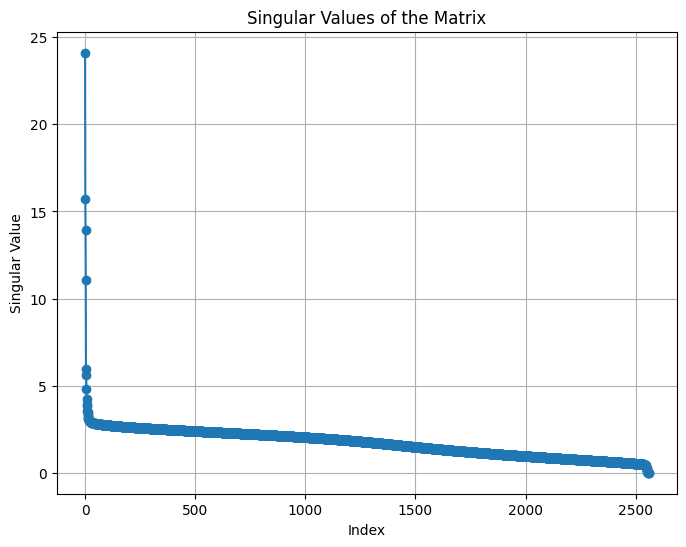

In [49]:
def plot_singular_values(mtx):
    """
    Plot the singular values of a given matrix using PyTorch and Matplotlib.

    Parameters:
    mtx (torch.Tensor): The matrix for which to compute and plot the singular values.
    """
    import torch
    import matplotlib.pyplot as plt
    mtx = mtx.detach().cpu().to(torch.float32)

    # Compute the Singular Value Decomposition (SVD)
    U, S, V = torch.svd(mtx)

    # Plotting the singular values
    plt.figure(figsize=(8, 6))
    R = 20
   
    plt.plot(S.numpy(), marker='o')
    plt.title('Singular Values of the Matrix')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.grid(True)
    plt.show()
    
plot_singular_values(w)

In [43]:
wo = mlp.fc1.weight.detach().to(torch.float32)

In [45]:

def svd_approx(W: torch.Tensor, r: int = None) -> Tuple[torch.Tensor, torch.Tensor, int, torch.Tensor]:
    U, S, V = torch.linalg.svd(W, full_matrices=False)
    if r is None:
        r = S.size(0)
    else:
        r = min(r, S.size(0))

    A = U[:, :r]
    B = torch.diag(S[:r]) @ V[:r, :]
    approx_W = A @ B
    frobenius_norm = torch.linalg.norm(W - approx_W)
    return A, B, r, frobenius_norm

r = 20
A,B,_,_ = svd_approx(wo,r=r)

In [46]:
We = wo - A@B

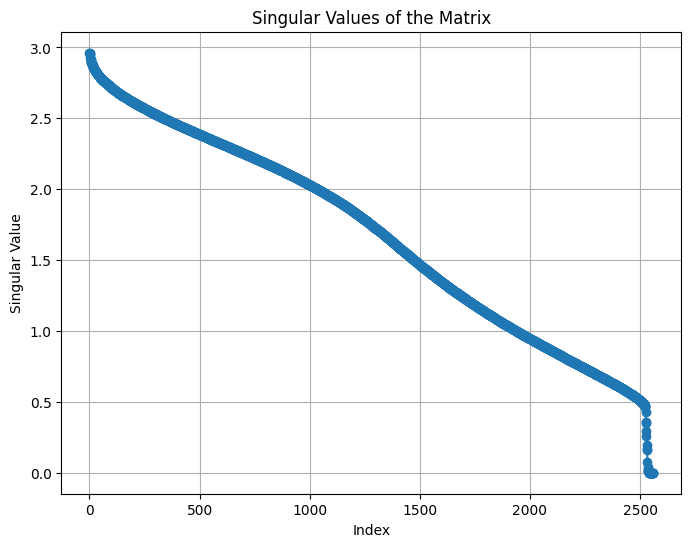

In [50]:
plot_singular_values(We)

In [53]:
A.shape,B.shape

(torch.Size([10240, 20]), torch.Size([20, 2560]))

In [75]:
import torch.nn.functional as F
cpu = torch.device("cpu")
A = A.to(cpu)
B = B.to(cpu)

In [79]:
class Wmap(nn.Module):
    def __init__(self,in_shape,out_shape,hidden=None):
        super().__init__()
        if hidden is None:
            hidden = (in_shape+out_shape)//2
        self.up_a = nn.Linear(in_shape,hidden,bias=False)
        self.up_b = nn.Linear(in_shape,hidden,bias=False)
        self.gate_a = nn.Linear(in_shape,hidden,bias=False)
        self.gate_b = nn.Linear(in_shape,hidden,bias=False)
        self.act = nn.SiLU()
    
    def forward(self,a,b):
        a = self.up_a(a)
        b = self.up_b(b.T).T 
        gate_a = self.gate_a(a)
        gate_b = self.gate_b(b.T).T
        return self.act(a)@b + gate_a@self.act(gate_b)

compresser = Wmap(r,r).to(cpu)    

compresser(A,B).shape,We.shape

(torch.Size([10240, 2560]), torch.Size([10240, 2560]))

In [80]:
Iters = 1000
optimizer = torch.optim.AdamW(compresser.parameters(),lr=1e-3)

for idx in range(Iters):
    pred = compresser(A,B)
    loss = F.mse_loss(We,pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(idx,loss.item())

0 0.00032200655550695956
1 0.0003219250647816807
2 0.00032184840529225767
3 0.00032177637331187725
4 0.00032170870690606534
5 0.0003216451732441783
6 0.00032158553949557245
7 0.00032152957282960415
8 0.00032147709862329066
9 0.00032142779673449695
10 0.00032138157985173166
11 0.00032133812783285975
12 0.00032129738247022033
13 0.0003212590527255088
14 0.00032122302218340337
15 0.00032118920353241265
16 0.00032115739304572344
17 0.00032112744520418346
18 0.0003210993018001318
19 0.00032107281731441617
20 0.00032104793353937566
21 0.000321024504955858
22 0.0003210025024600327
23 0.0003209817805327475
24 0.00032096225186251104
25 0.00032094388734549284
26 0.00032092665787786245
27 0.00032091038883663714
28 0.0003208951384294778
29 0.0003208807611372322
30 0.00032086719875223935
31 0.00032085448037832975
32 0.0003208424896001816
33 0.00032083119731396437
34 0.0003208205453120172
35 0.00032081047538667917
36 0.00032080107484944165
37 0.000320792110869661
38 0.0003207836707588285
39 0.000320

In [72]:
((10240 * 2560) - (10240*30+ 30* 2560) + 30*30*8)/ (10240 * 2560)

0.985626220703125

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
B,T,C = 1,7,3

In [33]:
k=q=v=torch.rand(B,T,C)

In [34]:
def ret(k,q,v):
    ret = q@k.transpose(-1,-2)
    return ret@v
ret(k,q,v)

tensor([[[4.0560, 3.6577, 2.7222],
         [3.1794, 2.6339, 2.5851],
         [2.4308, 2.0832, 2.0159],
         [1.9744, 1.8662, 1.5995],
         [2.6375, 2.4624, 2.5261],
         [3.3000, 3.0506, 3.2274],
         [4.1144, 3.6721, 3.1935]]])

In [10]:
(k.unsqueeze(-1) @ v.unsqueeze(-2)).shape

torch.Size([1, 7, 3, 3])

In [ ]:
h = 

$$
h = Ah+Bx \newline
y = Ch+Dx
$$

$$
h = Ih \space + \space x\cdot Wk \space @  \space  x\cdot Wv  \newline
y = q@h
$$

In [55]:
mask = torch.tril(torch.ones(1,T,T))

In [56]:
mask

tensor([[[1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1.]]])

In [61]:
idp_mask = k.sum(-1).unsqueeze(1).expand(-1,T,-1) * mask

idp_mask

tensor([[[2.6762, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.6762, 0.8321, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.6762, 0.8321, 0.9354, 0.0000, 0.0000, 0.0000, 0.0000],
         [2.6762, 0.8321, 0.9354, 1.0047, 0.0000, 0.0000, 0.0000],
         [2.6762, 0.8321, 0.9354, 1.0047, 0.9372, 0.0000, 0.0000],
         [2.6762, 0.8321, 0.9354, 1.0047, 0.9372, 1.8718, 0.0000],
         [2.6762, 0.8321, 0.9354, 1.0047, 0.9372, 1.8718, 1.5302]]])

In [69]:
1/(idp_mask**2)

tensor([[[0.1396,    inf,    inf,    inf,    inf,    inf,    inf],
         [0.1396, 1.4443,    inf,    inf,    inf,    inf,    inf],
         [0.1396, 1.4443, 1.1428,    inf,    inf,    inf,    inf],
         [0.1396, 1.4443, 1.1428, 0.9907,    inf,    inf,    inf],
         [0.1396, 1.4443, 1.1428, 0.9907, 1.1385,    inf,    inf],
         [0.1396, 1.4443, 1.1428, 0.9907, 1.1385, 0.2854,    inf],
         [0.1396, 1.4443, 1.1428, 0.9907, 1.1385, 0.2854, 0.4271]]])

In [13]:
W = torch.rand(3,27)

In [47]:
T=4
k=q=v=torch.rand(B,T,C)

k = torch.stack((k,torch.ones_like(k).float()*1e-2),dim=-2).reshape(B,2*T,C)
q = torch.stack((q,torch.ones_like(q).float()*1e-2),dim=-2).reshape(B,2*T,C)
v = torch.stack((v,torch.ones_like(v).float()*1e-2),dim=-2).reshape(B,2*T,C)

In [51]:
torch.round(k@q.transpose(-1,-2),decimals=2)

tensor([[[0.3300, 0.0100, 0.3300, 0.0100, 0.3600, 0.0100, 0.5100, 0.0100],
         [0.0100, 0.0000, 0.0100, 0.0000, 0.0200, 0.0000, 0.0200, 0.0000],
         [0.3300, 0.0100, 0.6200, 0.0100, 0.8500, 0.0100, 0.8300, 0.0100],
         [0.0100, 0.0000, 0.0100, 0.0000, 0.0200, 0.0000, 0.0200, 0.0000],
         [0.3600, 0.0200, 0.8500, 0.0200, 1.7800, 0.0200, 1.6500, 0.0200],
         [0.0100, 0.0000, 0.0100, 0.0000, 0.0200, 0.0000, 0.0200, 0.0000],
         [0.5100, 0.0200, 0.8300, 0.0200, 1.6500, 0.0200, 1.6800, 0.0200],
         [0.0100, 0.0000, 0.0100, 0.0000, 0.0200, 0.0000, 0.0200, 0.0000]]])